    Install modules

In [1]:
import geopandas as gpd #gpd for creating geodatabases, tables with geometry data
import matplotlib.pyplot as plt 
import pandas as pd

Load crime data data 

In [2]:
crime = gpd.read_file('crimeDataEdit3.csv') #crime data csv
crime.crs = 'epsg:27700'
crime.head 

<bound method NDFrame.head of                                             WKT    Month              X  \
0     POINT (599261.905971669 249257.230574292)  2022-02  0.90825100000   
1     POINT (599365.899443736 249576.241500435)  2022-02  0.90995400000   
2     POINT (599261.905971669 249257.230574292)  2022-02  0.90825100000   
3      POINT (599161.89048438 249528.304176689)  2022-02  0.90695100000   
4      POINT (599161.89048438 249528.304176689)  2022-02  0.90695100000   
...                                         ...      ...            ...   
4471                                POINT EMPTY  2022-02  0.00000000000   
4472                                POINT EMPTY  2022-02  0.00000000000   
4473                                POINT EMPTY  2022-02  0.00000000000   
4474                                POINT EMPTY  2022-02  0.00000000000   
4475                                POINT EMPTY  2022-02  0.00000000000   

                   Y                    Crime_type  \
0     52.105755

Load parish data

In [3]:
parishes = gpd.read_file('parishBound.csv') #csv with wkt for parish boundaries
parishes.crs = 'epsg:27700'
parishes.head

<bound method NDFrame.head of                                                    WKT OBJECTID PD_ID  \
0    MULTIPOLYGON (((601704.701 253781.905,601737.4...     1534  MRNG   
1    MULTIPOLYGON (((604662.501 255212.495,604688.3...     1535  MBTT   
2    MULTIPOLYGON (((602301.998 251004.6,602329.998...     1536  MGBR   
3    MULTIPOLYGON (((600038.201 261253.496,600071.0...     1537  MSHE   
4    MULTIPOLYGON (((600928.099 258621.3,600937.004...     1538  MGFI   
..                                                 ...      ...   ...   
772  MULTIPOLYGON (((604662.501 255212.495,604698.3...    28945  MBDL   
773  MULTIPOLYGON (((607822.1 255743.803,607830.303...    28946  MNMN   
774  MULTIPOLYGON (((608122.698 254787.397,608126.4...    28947  MNMS   
775  MULTIPOLYGON (((601334.102 254683.297,601346.8...    28948  MCOM   
776  MULTIPOLYGON (((601208.101 254865.105,601225.5...    28949  MLFI   

             County            Distric_Bo                         Ward  \
0    Suffolk County

Convert dataframe to geodataframe with geometry values. MAY NOT BE NEEDED

In [ ]:
#crime = geopandas.GeoDataFrame(
    #df, geometry=geopandas.points_from_xy(df.X, df.Y))
#crime.crs = 'epsg:27700'
#crime.head

Test gdf have same crs

In [4]:
print(crime.crs == parishes.crs)

True


Display gdf layer

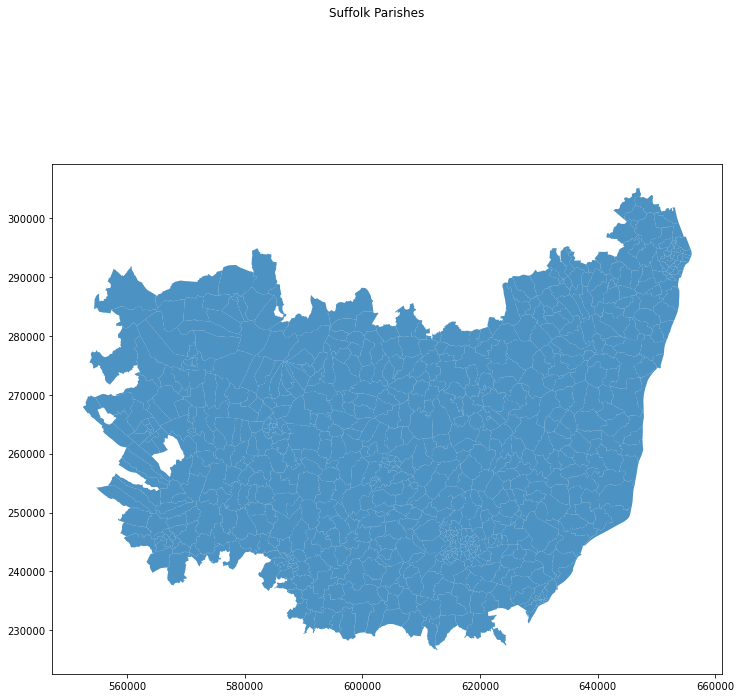

In [5]:
f, ax = plt.subplots(1, figsize=(12, 12))
ax = parishes.plot(ax=ax, alpha=0.8) #adjust alpha value to change colour intensity
#ax.set_axis_off()  #uncomment this line to remove national grid numbers
f.suptitle('Suffolk Parishes')
plt.show() 

Load a single parish using row number

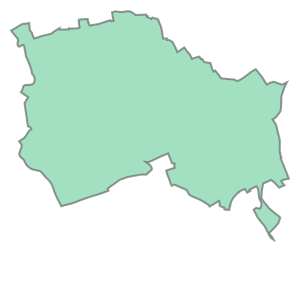

In [6]:
parishes.loc[0, 'geometry'] #adjust number to select parish

Plot data to scattergraph showing grid references. 

<AxesSubplot:>

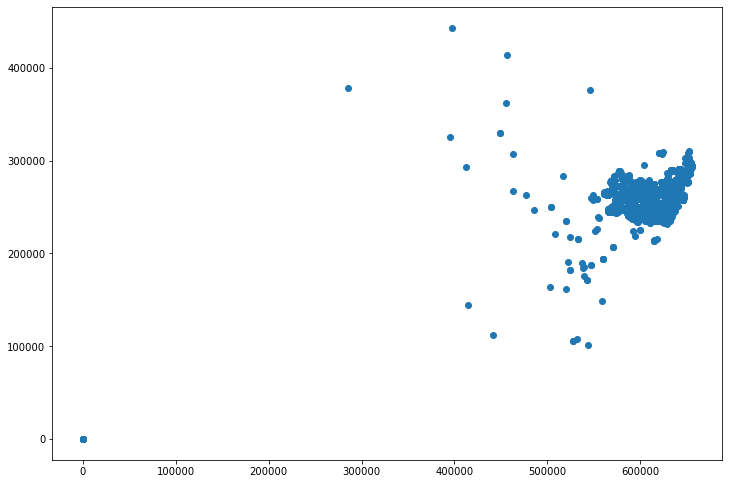

In [7]:
crime.plot(figsize=(12,10))

Clip the crime gdf data to the parish gdf so it only shows crimes taking place in Suffolk Parishes

In [8]:
clipped = []
for parish in parishes['Parish'].unique():
    tmp_clip = gpd.clip(crime, parishes[parishes['Parish'] == parish])
    clipped.append(tmp_clip)

clipped_gdf = gpd.GeoDataFrame(pd.concat(clipped))
clip_total = clipped_gdf.count()

clip_total

WKT           4358
Month         4358
X             4358
Y             4358
Crime_type    4358
geometry      4358
dtype: int64

Rename clipped_gdf to crimes and set CRS to 27700. Display clipped crime scattergraph

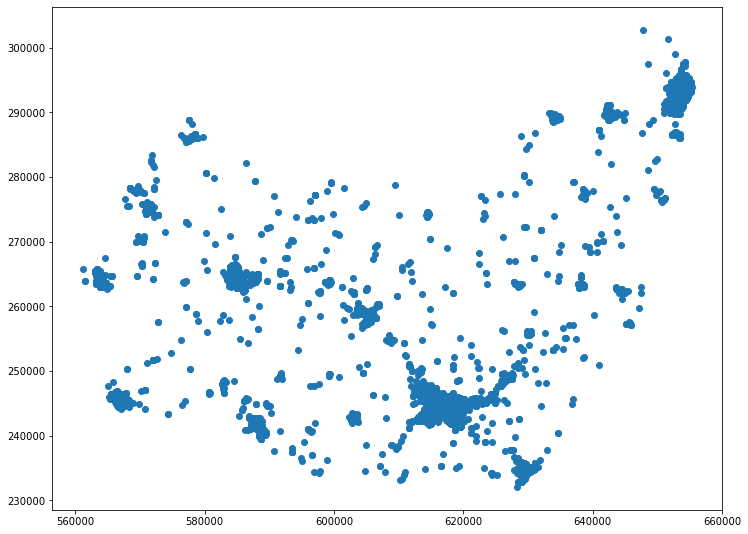

In [9]:
crimes = clipped_gdf
crimes.crs = 'epsg:27700'
crimes.plot(figsize=(12,10));

Join the two tables, crimes and parish

In [10]:
join = gpd.sjoin(parishes, crimes, how='inner', lsuffix='left', rsuffix='right') # perform the spatial join
join # show the joined table

,WKT_left,OBJECTID,PD_ID,County,Distric_Bo,Ward,Parish,geometry,index_right,WKT_right,Month,X,Y,Crime_type
2,"MULTIPOLYGON (((602301.998 251004.6,602329.998...",1536,MGBR,Suffolk County,Mid Suffolk District,Battisford & Ringshall Ward,Great Bricett CP,"MULTIPOLYGON (((602301.998 251004.600, 602329....",2272,POINT (603920.936556142 250661.180287565),2022-02,0.97702400000,52.11666400000,Anti-social behaviour
2,"MULTIPOLYGON (((602301.998 251004.6,602329.998...",1536,MGBR,Suffolk County,Mid Suffolk District,Battisford & Ringshall Ward,Great Bricett CP,"MULTIPOLYGON (((602301.998 251004.600, 602329....",2273,POINT (605155.963871697 251138.265054078),2022-02,0.99532300000,52.12049100000,Burglary
4,"MULTIPOLYGON (((600928.099 258621.3,600937.004...",1538,MGFI,Suffolk County,Mid Suffolk District,Onehouse Ward,Great Finborough CP,"MULTIPOLYGON (((600928.099 258621.300, 600937....",2161,POINT (601466.87963432 257915.110098903),2022-02,0.94553100000,52.18269400000,Burglary
5,"MULTIPOLYGON (((600220.401 259177.101,600248.5...",1539,MONE,Suffolk County,Mid Suffolk District,Onehouse Ward,Onehouse CP,"MULTIPOLYGON (((600220.401 259177.101, 600248....",2164,POINT (602865.88762386 258661.147032688),2022-02,0.96641100000,52.18888000000,Vehicle crime
5,"MULTIPOLYGON (((600220.401 259177.101,600248.5...",1539,MONE,Suffolk County,Mid Suffolk District,Onehouse Ward,Onehouse CP,"MULTIPOLYGON (((600220.401 259177.101, 600248....",2163,POINT (602384.869897096 259599.095943035),2022-02,0.95994400000,52.19747800000,Public order
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,"MULTIPOLYGON (((608122.698 254787.397,608126.4...",28947,MNMS,Suffolk County,Mid Suffolk District,Needham Market Ward,Needham Market CP,"MULTIPOLYGON (((608122.698 254787.397, 608126....",2264,POINT (608545.945961306 254953.206878453),2022-02,1.04710300000,52.15347400000,Violence and sexual offences
774,"MULTIPOLYGON (((608122.698 254787.397,608126.4...",28947,MNMS,Suffolk County,Mid Suffolk District,Needham Market Ward,Needham Market CP,"MULTIPOLYGON (((608122.698 254787.397, 608126....",2266,POINT (608760.964797195 254977.174199687),2022-02,1.05025600000,52.15360800000,Violence and sexual offences
774,"MULTIPOLYGON (((608122.698 254787.397,608126.4...",28947,MNMS,Suffolk County,Mid Suffolk District,Needham Market Ward,Needham Market CP,"MULTIPOLYGON (((608122.698 254787.397, 608126....",2262,POINT (608434.999115841 254996.106485603),2022-02,1.04551000000,52.15390100000,Other theft
775,"MULTIPOLYGON (((601334.102 254683.297,601346.8...",28948,MCOM,Suffolk County,Mid Suffolk District,Onehouse Ward,Combs CP,"MULTIPOLYGON (((601334.102 254683.297, 601346....",2166,POINT (602626.881063115 255391.155771136),2022-02,0.96096800000,52.15960800000,Violence and sexual offences


Select crime type by parish.

In [11]:
crime_stats = join.groupby(['Parish', 'Crime_type']).count()
print(crime_stats.loc['Sproughton CP']) #Edit to select parish of interest

                              WKT_left  OBJECTID  PD_ID  County  Distric_Bo  \
Crime_type                                                                    
Anti-social behaviour                2         2      2       2           2   
Other crime                          1         1      1       1           1   
Shoplifting                          1         1      1       1           1   
Violence and sexual offences         1         1      1       1           1   

                              Ward  geometry  index_right  WKT_right  Month  \
Crime_type                                                                    
Anti-social behaviour            2         2            2          2      2   
Other crime                      1         1            1          1      1   
Shoplifting                      1         1            1          1      1   
Violence and sexual offences     1         1            1          1      1   

                              X  Y  
Crime_type   

Display the overall number of crimes per parish

In [12]:
print(join.groupby(['Parish'])['Crime_type'].count())

Parish
                            1223
Acton CP                       7
Aldeburgh CP                  10
Aldringham cum Thorpe CP       3
Assington CP                   5
                            ... 
Worlingham CP                 13
Worlingworth CP                1
Wortham CP                     1
Wrentham CP                    2
Yoxford CP                     5
Name: Crime_type, Length: 264, dtype: int64


Generate Choropleth map of crimes report by parish

<AxesSubplot:>

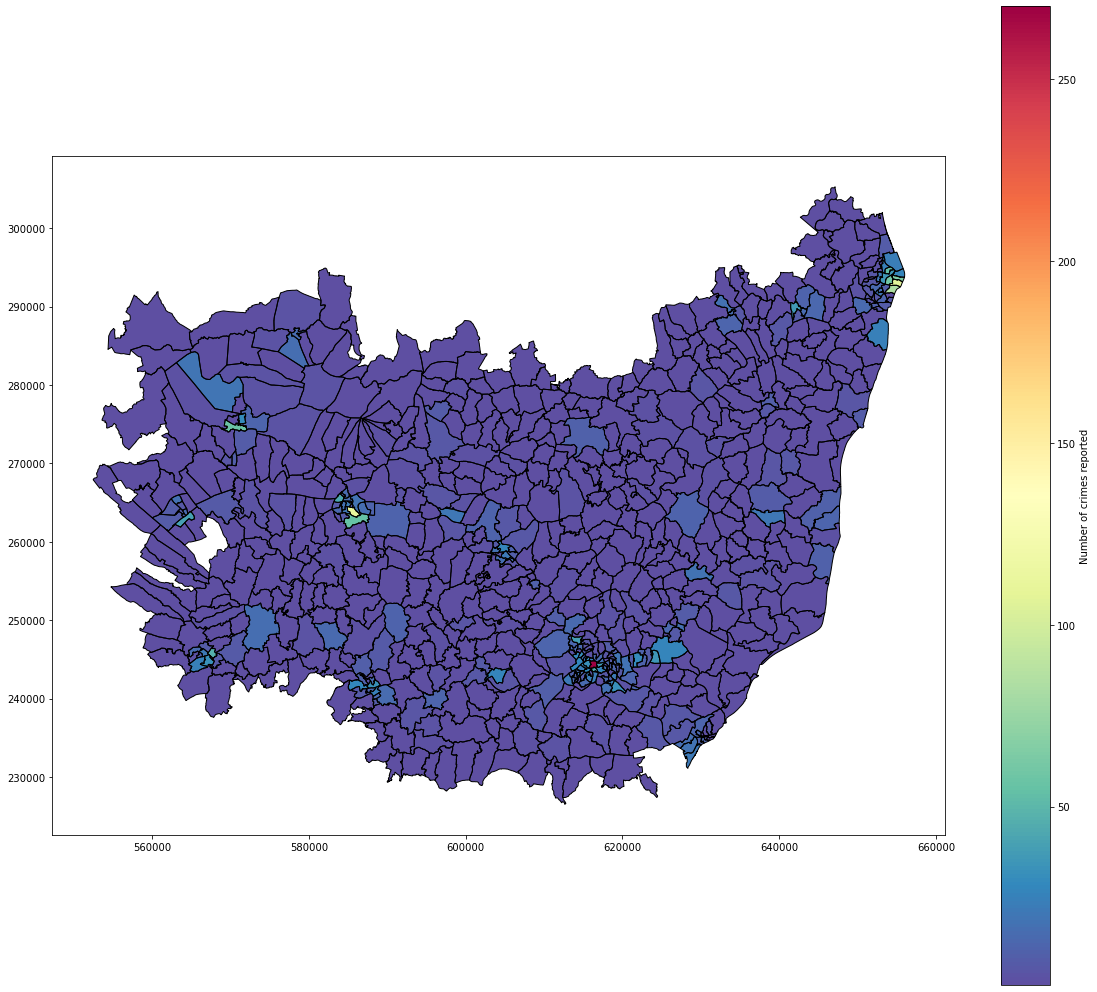

In [27]:
polygons = parishes
polygon_id_field = 'OBJECTID'
points = crimes
points.crs = 'epsg:27700'

sjoin = gpd.sjoin(parishes, crimes, how='left', predicate='contains')
count = sjoin.groupby(polygon_id_field)[polygon_id_field].count()
count.name='pointcount'
polygons = pd.merge(left=polygons, right=count, left_on=polygon_id_field, right_index=True)

fig, ax = plt.subplots(figsize = (20,18))
polygons.plot(column = 'pointcount', cmap = 'Spectral_r', ax=ax, legend=True,
              legend_kwds={'label':'Number of crimes reported'})
polygons.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 1, ax=ax)

In [ ]:
f, ax = plt.subplots(1, figsize=(12, 12))
ax = parishes.plot(ax=ax, alpha=0.8) #adjust alpha value to change colour intensity
#ax.set_axis_off()  #uncomment this line to remove national grid numbers
f.suptitle('Suffolk Parishes')
plt.show()

crimes.plot(figsize=(12,10));

fig, ax = plt.subplots(figsize = (20,18))
polygons.plot(column = 'pointcount', cmap = 'Spectral_r', ax=ax, legend=True,
              legend_kwds={'label':'Number of crimes reported'})
polygons.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 1, ax=ax)
